In [1]:
# Load the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in src, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../') 

from src.utils import datacollector
from src.utils import constants as cst
from src.utils import utils
from src.visualization import visualization as viz
from src.visualization import query as q
from src.preprocessing import cleaning

%matplotlib inline

In [52]:
# Let's load the datasets
df_lst = pd.read_csv(datacollector.get_data_file(cst.LISTING_FULL_FILE), sep=',', header=0, low_memory=False)
df_cal = pd.read_csv(datacollector.get_data_file(cst.CALENDAR_FILE), sep=',', header=0)
# df_reviews = pd.read_csv(datacollector.get_data_file(cst.REVIEWS_FILE), sep=',', header=0)

# Want to know more about what's inside data ?
Welcome to the _Appendix_ section. This is not directly linked to our main objectives but as I am a curious guy, I could not resist to dig more some elements.  
Indeed, we have seen in the first [notebook](1_Data_Understanding.ipynb) that there are interesting and sometimes even strange things that deserves our attention in this dataset. Here are the things I will explore more deeply:
* Usage of the service over time since the beginning
* Hosts: where are they from when not from Paris ?
* Hosts: some of them require guest picture/phone, what kind of listings are concerned ?
* Hosts: some of them owns a lot of apartments (one even owns 323 apartments/rooms to rent). What are those listings (type, place, price, etc) ?
* Listings: one of them cost around 10000€ for 1 night. Seriously ? What is it ?
* Listings: some of them have a strange `minimum number of nights` value...what are those outliers ?
* Listings: one of them is an igloo. Really ?
* Reviews: we have seen that one listing has 31 reviews per month in average, how is that even possible ?

## Airbnb service usage
### Most ancient user in Paris
Airbnb was founded in 2008. Let's see who is the most ancient user of the service in Paris.  

In [6]:
print("The most ancient user joined on {}".format(df_lst[df_lst['host_since'].notnull()].host_since.min()))

The most ancient user joined on 2008-08-22


###  Number of users growth over time
Let's remember that in the first analysis we have seen that for the `host_since` feature in the `listings.csv.gz` dataset values were:

In [7]:
q.print_basic_info_for_feature(df_lst, 'host_since')

There are 3334 different values for the 'host_since' feature.
There are 64 missing values (0.10%).
Here is a sample:
['2008-10-14' '2009-02-14' '2008-08-30' ... '2019-07-07' '2019-07-08'
 '2019-07-09']


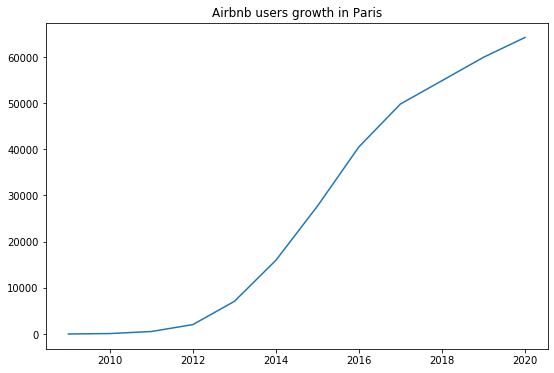

In [24]:
host_df = df_lst[df_lst['host_since'].notnull()][['host_since', 'id']]
host_df['host_since'] = pd.to_datetime(host_df['host_since'])
host_df = host_df.set_index('host_since').resample('Y')
figure, axis = plt.subplots(1, 1, figsize=(9, 6))
axis.set_title("Airbnb users growth in Paris")
sns.lineplot(data=np.cumsum(host_df.id.count()), markers=True, ax=axis)
plt.show()

Impressive, it took almost 3 to 4 years to grow up but only 5 years more to reach 50K users with a linear progression over years.

---
## Hosts exploration
### Where are they from when not from Paris or France ?
We will explore the feature `host_location` from `listings.csv.gz` dataset.

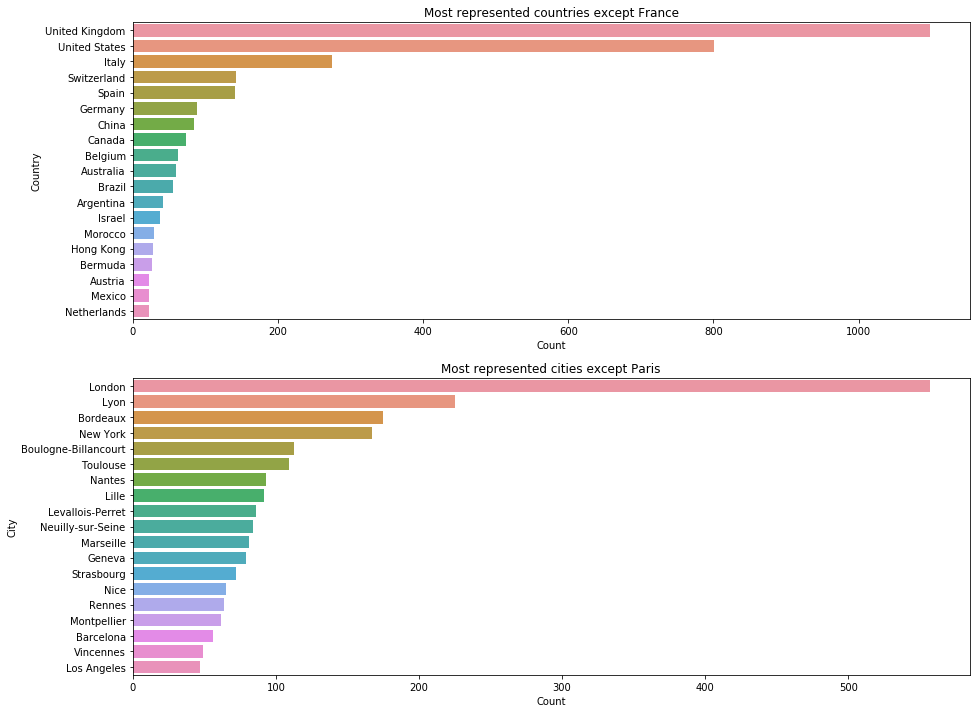

In [78]:
viz.barplot_hostlocation(df_lst)

**93.5% of owners live in France, 73.6% in Paris**. The next most represented city is not a french one but the England capital: _London_. Then we have big french cities: _Lyon_ , _Bordeaux_ , _Lille_ but not only french cities: _New York_ !!

### Hosts who requires guest picture, what kind of listings are concerned ?


In [7]:
# Filter the initial dataframe
host_guest_pic_df = df_lst[df_lst['require_guest_profile_picture'] == 't']
host_guest_pic_df.room_type.value_counts()

Entire home/apt    446
Private room        61
Shared room          2
Name: room_type, dtype: int64

In [6]:
host_guest_pic_df.neighbourhood_cleansed.value_counts()

Temple                 56
Buttes-Montmartre      50
Popincourt             50
Entrepôt               39
Ménilmontant           32
Vaugirard              31
Buttes-Chaumont        30
Batignolles-Monceau    27
Hôtel-de-Ville         26
Reuilly                22
Panthéon               21
Opéra                  20
Luxembourg             18
Palais-Bourbon         15
Passy                  15
Louvre                 13
Bourse                 13
Observatoire           12
Gobelins               11
Élysée                  8
Name: neighbourhood_cleansed, dtype: int64

In [11]:
currency_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
host_guest_pic_df = cleaning.clean_currency_columns(host_guest_pic_df, currency_cols)

In [12]:
host_guest_pic_df.price.describe()

count    509.000000
mean     118.074656
std       86.901963
min       25.000000
25%       68.000000
50%       90.000000
75%      140.000000
max      921.000000
Name: price, dtype: float64

***Observations:*** there is no easy clue to guess what is the difference for those 509 listings:
* The `room_type` distribution follows the full dataset one's
* Same observation for `neighbourhood` (I was expecting something different)
* And same observation for price (I was first expecting that it was for expensive listings but no).

It is just like that, some people wants to have the picture of their guest and there is no simple reason for that.

### Hosts with multiple listings
According to some figures in `listings.csv.gz` dataset, some people owns a lot of apartments (one even owns 323 apartments/rooms to rent). What are those listings (type, place, price, etc) ?

In [29]:
df_lst.groupby('host_id').host_id.count().sort_values().tail()

host_id
2667370     141
7642792     179
33889201    184
6053288     305
76104209    323
Name: host_id, dtype: int64

In [37]:
top_owner_lst = df_lst[df_lst['host_id'] == 76104209]
top_owner_lst.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
28606,17814399,https://www.airbnb.com/rooms/17814399,20190709213457,2019-07-10,1700SQF 2BR RIVER VIEW~NEXT TO SEINE&MUSEE D'O...,"My place is good for couples, solo adventurers...","This beautiful 1700 sq ft apartment, located i...","My place is good for couples, solo adventurers...",none,NaN,...,f,f,super_strict_60,f,f,323,304,19,0,NaN
30769,19112330,https://www.airbnb.com/rooms/19112330,20190709213457,2019-07-10,83SQM 3 BEDROOM WITH EIFFEL VIEWS,"3 Bedroom, apartment located on boulevard de L...",Located in a small quiet street at a walking d...,"3 Bedroom, apartment located on boulevard de L...",none,NaN,...,f,f,super_strict_60,f,f,323,304,19,0,0.04
31057,19257110,https://www.airbnb.com/rooms/19257110,20190709213457,2019-07-11,160SQM RARE 3BR/3BATH -AVE DES CHAMPS ELYSEES,"My place is close to Arc de Triomphe, Galeries...",LUXURY & STYLE~GLAMOROUS 3 BEDROOM/3 BATHROOM ...,"My place is close to Arc de Triomphe, Galeries...",none,NaN,...,f,f,super_strict_60,f,f,323,304,19,0,0.08
31434,19419077,https://www.airbnb.com/rooms/19419077,20190709213457,2019-07-11,PLEASANT 1BR IN 5TH~MOUFFETARD/ST. MICHEL/PANT...,Mouffetard - Left Bank is a luxury apartment r...,This is a Non-Smoking Apartment. On the Left B...,Mouffetard - Left Bank is a luxury apartment r...,none,NaN,...,f,f,super_strict_60,f,f,323,304,19,0,NaN
31767,19560032,https://www.airbnb.com/rooms/19560032,20190709213457,2019-07-11,"ST GERMAIN/MUSEE D'ORSAY,RUE DU BAC-CITY HEART...",Who wouldn't dream of staying on such a calm a...,This prestigious 110 m² duplex is located on R...,Who wouldn't dream of staying on such a calm a...,none,NaN,...,f,f,super_strict_60,f,f,323,304,19,0,NaN


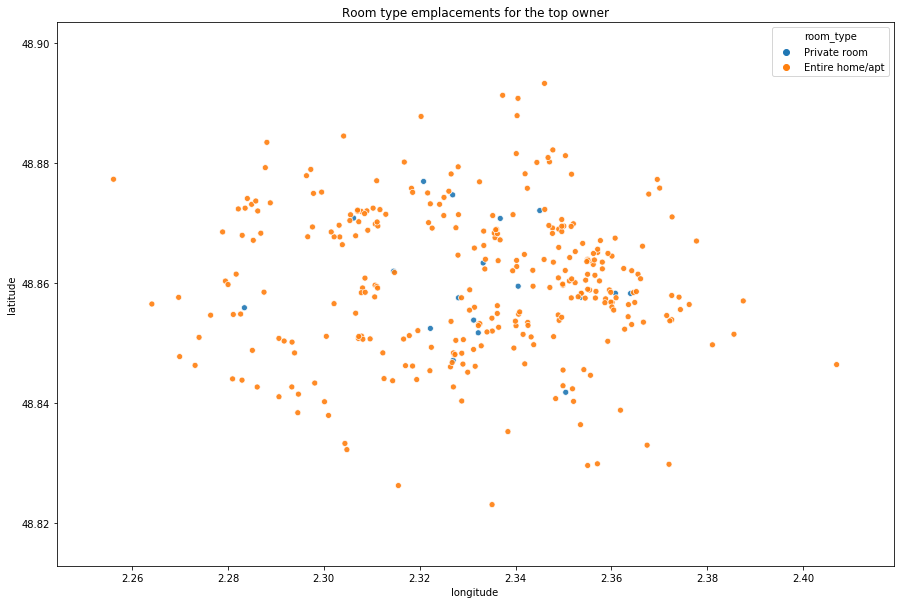

In [35]:
viz.scatterplot_xy_all_places(top_owner_lst, 'room_type', 'Room type emplacements for the top owner')

In [39]:
top_owner_lst.minimum_nights.value_counts().sort_index()

1        2
4        6
5       37
6        3
7      107
10       2
11       2
14       3
15       5
20       1
21       1
28       4
30     109
31       1
45       2
60       9
90      17
120      4
150      1
180      6
365      1
Name: minimum_nights, dtype: int64

In [43]:
top_owner_lst = cleaning.clean_currency_columns(top_owner_lst, ['price'])
top_owner_lst.price.describe()

count     323.000000
mean      451.269350
std       308.282054
min       100.000000
25%       250.000000
50%       350.000000
75%       550.000000
max      2000.000000
Name: price, dtype: float64

***Observations:***  
This seems to be true. There is someone in this world who owns more than 300 rooms to rent in Paris ! They are not located at the same place and are to rent for at least:
* 1 month for 33% of them
* 1 week for another 33% of them

Average price for 1 night is 451 euros, which is a lot.

This is a real business !

---
### Places
### Where is the igloo ?

In [46]:
df_lst[df_lst.property_type == 'Igloo'].id

7228    4311177
Name: id, dtype: int64

Let's check online:

<img src="../assets/igloo.png" width="500" />
The listing is a real one but it seems to be a joke regarding the description. Host even said that there is a fitness room and an elevator ;-).

### Where is the most expensive place to rent ? What is it ?

In [48]:
df_lst = cleaning.clean_currency_columns(df_lst, ['price'])

In [50]:
df_lst[df_lst.price == df_lst.price.max()].id

12781    7225849
Name: id, dtype: int64

Unfortunately, at the moment this is written this listing is not available anymore so it is not possible to confirm whether this price is the real one or just a mistake somewhere:

<img src="../assets/airbnb_most_expensive_listing.png" width="500" />

In [53]:
# Let's confirm with the calendar dataset
df_cal[df_cal.listing_id == 7225849].price.value_counts()

$9,379.00    261
$150.00      104
Name: price, dtype: int64

In [54]:
df_cal[df_cal.listing_id == 7225849].available.value_counts()

f    365
Name: available, dtype: int64

***Observation:*** I guess this is more a mistake and that the real price is 150 euros when it is to rent and 9379 a setup value when not available.

In [69]:
df_lst.price.value_counts().sort_index().tail(10)

4000.0    1
5000.0    3
5150.0    1
8000.0    1
8288.0    1
8500.0    1
8576.0    1
8721.0    1
8921.0    1
9379.0    1
Name: price, dtype: int64

In [66]:
df_lst[df_lst.price == 8921].id

45792    27608896
Name: id, dtype: int64

In [67]:
df_cal[df_cal.listing_id == 27608896].available.value_counts()

f    365
Name: available, dtype: int64

One more....so I think I am right and those outliers value are all for unavailable listings. Let's filter listing with at least one availability:

In [71]:
df_lst[df_lst.availability_365 > 0].price.value_counts().sort_index().tail(10)

3000.0    2
3183.0    1
3325.0    1
4000.0    1
5000.0    3
5150.0    1
8000.0    1
8288.0    1
8576.0    1
8721.0    1
Name: price, dtype: int64

In [72]:
df_lst[df_lst.price == 8721].id

14622    8093890
Name: id, dtype: int64

In [73]:
df_cal[df_cal.listing_id == 8093890].available.value_counts()

t    231
f    134
Name: available, dtype: int64

<img src="../assets/airbnb_most_expensive_listing_real_one.png" width="500" />

This listing must be rented for at least 5 days so it will cost you something like 43 000 euros to stay here one week... Wow !

---
### Reviews
### What is the listing with 31 reviews per month in average ?

In [ ]:
# TODO: WIP